### Import Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time 
import matplotlib.pyplot as plt

### Import Data

In [2]:
X = pd.read_csv('dataset/fitur.csv').values
y = pd.read_csv('dataset/target.csv').values.flatten()

### Split Data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Modeling BBA-SVM

In [4]:
class BAA_SVM:
    def __init__(self, n_bats, n_features, max_iter, f_min, f_max, alpha, gamma):
        self.n_bats = n_bats
        self.n_features = n_features
        self.max_iter = max_iter
        self.f_min = f_min
        self.f_max = f_max
        self.alpha = alpha
        self.gamma = gamma

        # inisialisasi posisi, kecepatan, frekuensi, pulse rate, dan loudness
        self.positions = np.random.randint(2, size=(n_bats, n_features))
        self.velocities = np.zeros((n_bats, n_features))
        self.frequencies = np.zeros(n_bats)
        self.loudness = np.random.uniform(1, 2.000001, size=n_bats)
        self.pulse_rate = np.random.rand(n_bats)
        self.pulse_rate_initial = self.pulse_rate.copy()
        self.fitness_values = np.full(n_bats, -np.inf)

        # inisialisasi global best
        self.global_best_position = self.positions[0].copy()
        self.global_best_fitness = self.fitness(self.global_best_position)
        for i in range(self.n_bats):
            fitness = self.fitness(self.positions[i])
            if fitness > self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = self.positions[i].copy()

    # fungsi sigmoid / untuk perpindahan posisi partikel secara biner
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # fungsi objektif / fitness dengan SVM
    def fitness(self, position):
        selected_features = np.where(position == 1)[0]
        # pinalti jika tidak ada fitur yang terpilih
        if len(selected_features) == 0:
            return 0

        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]

        model = SVC(kernel='linear', C=10, gamma=0.1, random_state=42)
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return accuracy_score(y_test, y_pred)

    # fungsi optimasi BAA
    def optimize(self):
        for t in range(self.max_iter):
            for i in range(self.n_bats):
                # memperbarui frekuensi
                beta = np.random.rand()
                self.frequencies[i] = self.f_min + (self.f_max - self.f_min) * beta

                # memperbarui kecepatan
                self.velocities[i] += (self.global_best_position - self.positions[i]) * self.frequencies[i]
                # memperbarui posisi
                new_position = (np.random.rand(self.n_features) < self.sigmoid(self.velocities[i])).astype(int)

                # mengenerate posisi baru / lokal
                if np.random.rand() > self.pulse_rate[i]:
                    epsilon = np.random.uniform(-1, 1.000001, size=self.n_features)
                    new_position = self.global_best_position + epsilon * np.mean(self.loudness)
                    new_position = (np.random.rand(self.n_features) < self.sigmoid(new_position)).astype(int)

                # menghitung fitness
                new_fitness = self.fitness(new_position)

                # terima solusi baru jika meningkatkan fitness dan memenuhi ambang probabilitas
                if np.random.rand() < self.loudness[i] and new_fitness > self.fitness_values[i] :
                    self.positions[i] = new_position
                    self.fitness_values[i] = new_fitness

                    # memperbarui loudness and pulse rate
                    self.loudness[i] *= self.alpha
                    self.pulse_rate[i] *= self.pulse_rate_initial[i] * (1 - np.exp(-self.gamma * t))

                # memperbarui global best
                if new_fitness > self.global_best_fitness:
                    self.global_best_fitness = new_fitness
                    self.global_best_position = new_position

            print(f"Iteration {t + 1}/{self.max_iter}: Best Fitness = {self.global_best_fitness}")

        print("OPTIMASI SELESAI\n")
        return self.global_best_position, self.global_best_fitness

### Pengujian

##### Pengaruh jumlah iterasi terhadap waktu komputasi

In [5]:
def tuning():
    n_bats_values = [5]
    n_features = X.shape[1]
    max_iter_values = list(range(10, 201, 10))
    f_min_values = [0] 
    f_max_values = [2]
    alpha_values = [0.8] 
    gamma_values = [0.9]

    max_iter_list = []
    best_position_list = []
    best_features_list = []
    best_fitness_list = []
    duration_list = []

    i = 0
    for n_bats in n_bats_values:
        for max_iter in max_iter_values:
            for f_min in f_min_values:
                for f_max in f_max_values:
                    for alpha in alpha_values:
                        for gamma in gamma_values:
                            i += 1
                            print(f"\nKOMBINASI KE-{i}/{len(max_iter_values)}, MAX_ITER = {max_iter}")
                            start_time = time.time()
                            # inisialisasi bba
                            bba = BAA_SVM(
                                n_bats=n_bats,
                                n_features=n_features,
                                max_iter=max_iter,
                                f_min=f_min,
                                f_max=f_max,
                                alpha=alpha,
                                gamma=gamma
                            )
                            # optimasi
                            best_position, best_fitness = bba.optimize()
                            end_time = time.time()
                            durasi = end_time - start_time
                            best_features = np.where(best_position == 1)[0]
                            # simpan ke list
                            max_iter_list.append(max_iter)
                            best_position_list.append(best_position)
                            best_features_list.append(best_features)
                            best_fitness_list.append(best_fitness) 
                            duration_list.append(durasi) 
    hasil = pd.DataFrame({
        'max_iter': max_iter_list, 
        'best_position': best_position_list,
        'best_features': best_features_list,
        'best_fitness': best_fitness_list,
        'duration': duration_list
    })                                 
    return hasil

jumlahITER = tuning()
jumlahITER.to_csv('hasil uji/jumlahITER.csv', index=False)
jumlahITER.to_excel('hasil uji/jumlahITER.xlsx', index=False)


KOMBINASI KE-1/20, MAX_ITER = 10
Iteration 1/10: Best Fitness = 0.9824561403508771
Iteration 2/10: Best Fitness = 0.9824561403508771
Iteration 3/10: Best Fitness = 0.9824561403508771
Iteration 4/10: Best Fitness = 0.9824561403508771
Iteration 5/10: Best Fitness = 0.9824561403508771
Iteration 6/10: Best Fitness = 0.9824561403508771
Iteration 7/10: Best Fitness = 0.9824561403508771
Iteration 8/10: Best Fitness = 0.9824561403508771
Iteration 9/10: Best Fitness = 0.9824561403508771
Iteration 10/10: Best Fitness = 0.9824561403508771
OPTIMASI SELESAI


KOMBINASI KE-2/20, MAX_ITER = 20
Iteration 1/20: Best Fitness = 0.9824561403508771
Iteration 2/20: Best Fitness = 0.9824561403508771
Iteration 3/20: Best Fitness = 0.9824561403508771
Iteration 4/20: Best Fitness = 0.9824561403508771
Iteration 5/20: Best Fitness = 0.9824561403508771
Iteration 6/20: Best Fitness = 0.9824561403508771
Iteration 7/20: Best Fitness = 0.9824561403508771
Iteration 8/20: Best Fitness = 0.9824561403508771
Iteration 9/2

In [6]:
jumlahITER

,max_iter,best_position,best_features,best_fitness,duration
0,10,"[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...","[0, 1, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 20,...",0.982456,0.236415
1,20,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[4, 13, 14, 15, 17, 22, 23, 24, 25, 27, 29]",1.000000,0.434507
2,30,"[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...","[0, 1, 3, 7, 10, 11, 13, 14, 16, 17, 18, 20, 2...",0.982456,0.577965
3,40,"[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, ...","[0, 1, 3, 4, 5, 8, 11, 12, 13, 15, 20, 22, 29]",0.982456,0.714519
4,50,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, ...","[0, 1, 4, 8, 9, 11, 12, 14, 16, 17, 18, 21, 22...",0.982456,0.874687
5,60,"[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 2, 5, 6, 7, 11, 12, 15, 17, 18, 19, 21, 24...",0.982456,1.088232
6,70,"[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[2, 3, 4, 7, 11, 14, 15, 16, 18, 19, 20, 22, 2...",1.000000,1.223634
7,80,"[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 3, 6, 13, 16, 18, 19, 20, 22, 23, 25, 26, 29]",1.000000,1.463499
8,90,"[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, ...","[0, 1, 2, 3, 5, 7, 9, 11, 12, 13, 16, 17, 18, ...",0.982456,1.597866
9,100,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, ...","[0, 1, 2, 3, 5, 7, 8, 11, 12, 13, 16, 18, 20, ...",0.982456,1.734288


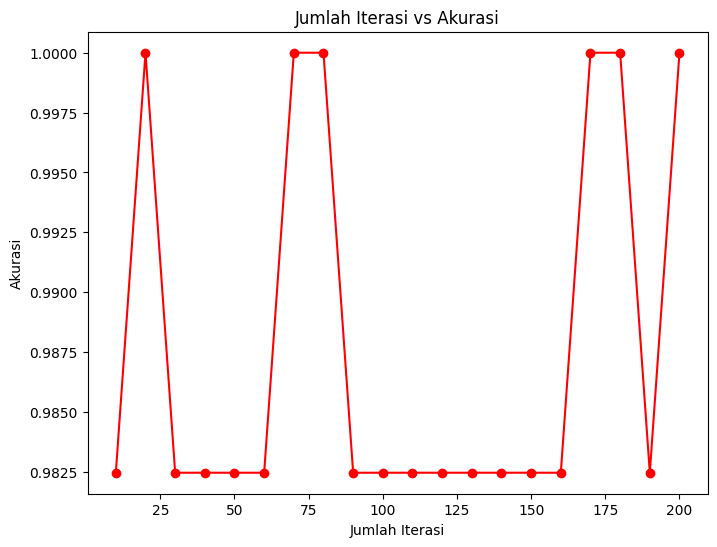

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(jumlahITER['max_iter'], jumlahITER['best_fitness'], marker='o', linestyle='-', color='r')
plt.title('Jumlah Iterasi vs Akurasi')
plt.xlabel('Jumlah Iterasi')
plt.ylabel('Akurasi')
plt.show()

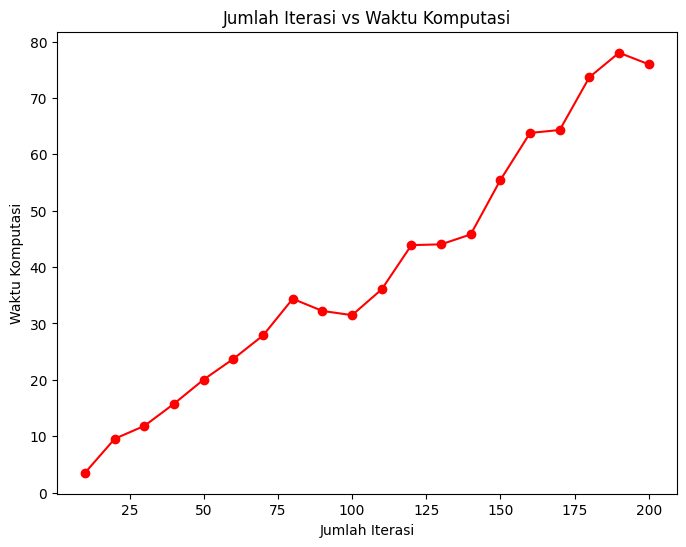

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(jumlahITER['max_iter'], jumlahITER['duration'], marker='o', linestyle='-', color='r')
plt.title('Jumlah Iterasi vs Waktu Komputasi')
plt.xlabel('Jumlah Iterasi')
plt.ylabel('Waktu Komputasi')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

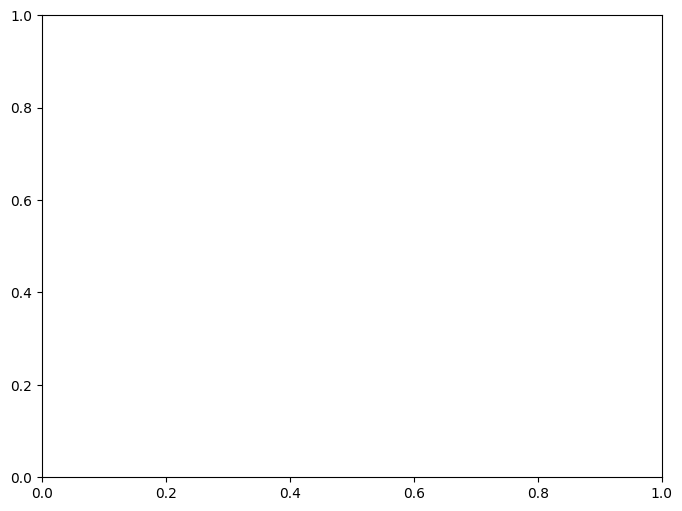

In [53]:
best_index = jumlahITER['best_fitness'].idxmin()
fitness_iteration_list = jumlahITER['fitness_iteration'][best_index]
plt.figure(figsize=(8, 6))
plt.plot(len(fitness_iteration_list), fitness_iteration_list, marker='o', linestyle='-', color='r')
plt.title('Iterasi vs Akurasi')
plt.xlabel('Iterasi ke-')
plt.ylabel('Akurasi')
plt.show()

##### Pengaruh f_min terhadap akurasi

In [44]:
def tuning():
    n_bats_values = [5]
    n_features = X.shape[1]
    max_iter_values = [100]
    f_min_values = list(np.arange(0.0, 2.1, 0.2)) 
    f_max_values = [2]
    alpha_values = [0.8] 
    gamma_values = [0.9]
    pulse_rate_values = [0.1] 
    loudness_values = [0.2]

    f_min_list = []
    best_solution_list = []
    best_features_list = []
    best_fitness_list = []
    duration_list = []

    i = 0
    for n_bats in n_bats_values:
        for max_iter in max_iter_values:
            for f_min in f_min_values:
                for f_max in f_max_values:
                    for alpha in alpha_values:
                        for gamma in gamma_values:
                            for pulse_rate in pulse_rate_values:
                                for loudness in loudness_values:
                                    i += 1
                                    print(f"\nKOMBINASI KE-{i}, F_MIN = {f_min}")
                                    start_time = time.time()
                                    # inisialisasi bba
                                    bba = BinaryBatAlgorithm(
                                        n_bats=n_bats,
                                        n_features=n_features,
                                        max_iter=max_iter,
                                        f_min=f_min,
                                        f_max=f_max,
                                        alpha=alpha,
                                        gamma=gamma,
                                        pulse_rate=pulse_rate,
                                        loudness=loudness
                                    )
                                    # optimasi
                                    best_solution, best_fitness = bba.optimize()
                                    end_time = time.time()
                                    durasi = end_time - start_time
                                    best_features = np.where(best_solution == 1)[0]
                                    # simpan ke list
                                    f_min_list.append(f_min)
                                    best_solution_list.append(best_solution)
                                    best_features_list.append(best_features)
                                    best_fitness_list.append(best_fitness)  
                                    duration_list.append(durasi) 
    hasil = pd.DataFrame({
        'f_min': f_min_list, 
        'best_solution': best_solution_list,
        'best_features': best_features_list,
        'best_fitness': best_fitness_list,
        'duration': duration_list
    })                                 
    return hasil

nilaiF_MIN = tuning()
nilaiF_MIN.to_csv('hasil uji/nilaiF_MIN.csv', index=False)
nilaiF_MIN.to_excel('hasil uji/nilaiF_MIN.xlsx', index=False)


KOMBINASI KE-1, F_MIN = 0.0
Iteration 1, Best Fitness: 0.9736842105263158
Iteration 2, Best Fitness: 0.9736842105263158
Iteration 3, Best Fitness: 0.9736842105263158
Iteration 4, Best Fitness: 0.9736842105263158
Iteration 5, Best Fitness: 0.9736842105263158
Iteration 6, Best Fitness: 0.9736842105263158
Iteration 7, Best Fitness: 0.9736842105263158
Iteration 8, Best Fitness: 0.9736842105263158
Iteration 9, Best Fitness: 0.9736842105263158
Iteration 10, Best Fitness: 0.9736842105263158
Iteration 11, Best Fitness: 0.9736842105263158
Iteration 12, Best Fitness: 0.9736842105263158
Iteration 13, Best Fitness: 0.9736842105263158
Iteration 14, Best Fitness: 0.9736842105263158
Iteration 15, Best Fitness: 0.9736842105263158
Iteration 16, Best Fitness: 0.9736842105263158
Iteration 17, Best Fitness: 0.9736842105263158
Iteration 18, Best Fitness: 0.9736842105263158
Iteration 19, Best Fitness: 0.9736842105263158
Iteration 20, Best Fitness: 0.9736842105263158
Iteration 21, Best Fitness: 0.9736842105

In [45]:
nilaiF_MIN

,f_min,best_solution,best_features,best_fitness,duration
0,0.0,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...","[2, 6, 10, 11, 12, 13, 15, 18, 19, 21, 23, 26,...",0.973684,20.331355
1,0.2,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, ...","[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 16, 18, 19, 21...",0.960526,19.848549
2,0.4,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, ...","[0, 2, 4, 6, 7, 12, 13, 15, 18, 19, 20, 21, 22...",0.960526,20.818338
3,0.6,"[1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, ...","[0, 1, 2, 5, 8, 9, 11, 14, 15, 16, 17, 19, 22,...",0.973684,20.348340
4,0.8,"[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 1, 4, 6, 12, 13, 14, 15, 22, 25, 26, 27, 2...",0.973684,18.891835
5,1.0,"[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 7, 9, 10, 17, 18, 20, 21, 2...",0.973684,17.645164
6,1.2,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, ...","[1, 3, 4, 6, 7, 10, 11, 13, 14, 15, 19, 21, 23...",0.960526,18.667110
7,1.4,"[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 3, 4, 7, 9, 12, 13, 16, 17, 18, 20, 22,...",0.960526,20.198178
8,1.6,"[1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...","[0, 1, 3, 4, 5, 7, 8, 11, 13, 15, 17, 20, 21, ...",0.960526,19.815211
9,1.8,"[1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","[0, 2, 4, 5, 8, 13, 14, 16, 17, 19, 22, 24, 25...",0.973684,18.269024


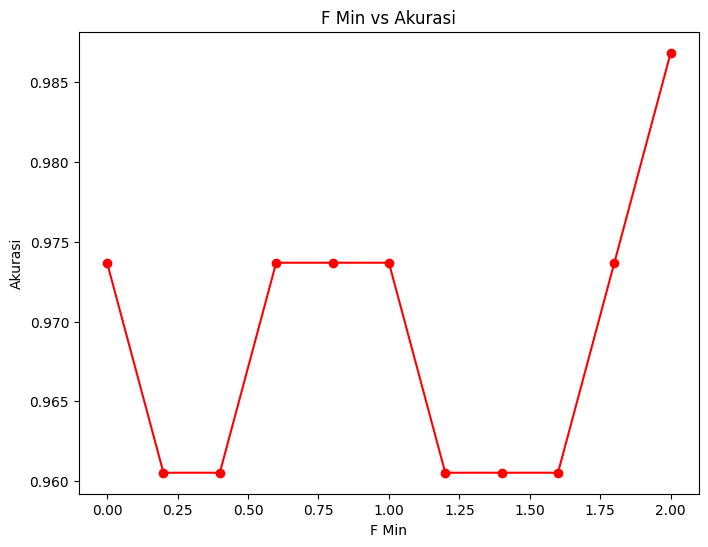

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiF_MIN['f_min'], nilaiF_MIN['best_fitness'], marker='o', linestyle='-', color='r')
plt.title('F Min vs Akurasi')
plt.xlabel('F Min')
plt.ylabel('Akurasi')
plt.show()

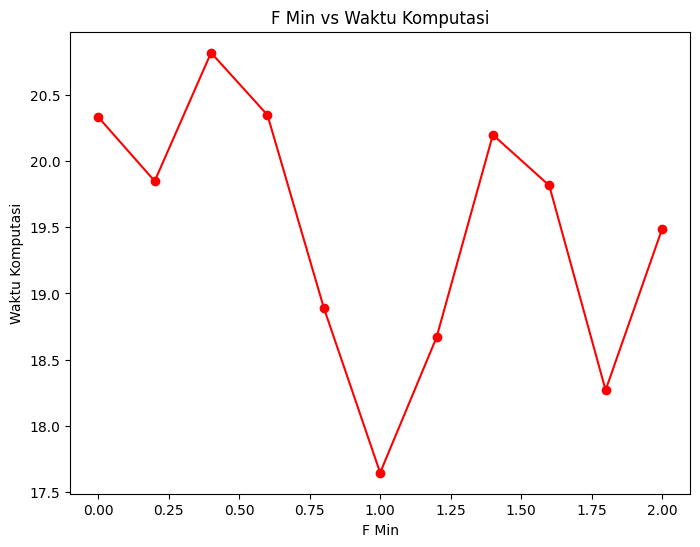

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiF_MIN['f_min'], nilaiF_MIN['duration'], marker='o', linestyle='-', color='r')
plt.title('F Min vs Waktu Komputasi')
plt.xlabel('F Min')
plt.ylabel('Waktu Komputasi')
plt.show()

##### Pengaruh f_max terhadap akurasi

In [49]:
def tuning():
    n_bats_values = [5]
    n_features = X.shape[1]
    max_iter_values = [100]
    f_min_values = [0] 
    f_max_values = list(np.arange(2, 10.1, 0.5)) 
    alpha_values = [0.8] 
    gamma_values = [0.9]
    pulse_rate_values = [0.1] 
    loudness_values = [0.2]

    f_max_list = []
    best_solution_list = []
    best_features_list = []
    best_fitness_list = []
    duration_list = []

    i = 0
    for n_bats in n_bats_values:
        for max_iter in max_iter_values:
            for f_min in f_min_values:
                for f_max in f_max_values:
                    for alpha in alpha_values:
                        for gamma in gamma_values:
                            for pulse_rate in pulse_rate_values:
                                for loudness in loudness_values:
                                    i += 1
                                    print(f"\nKOMBINASI KE-{i}, F_MAX = {f_max}")
                                    start_time = time.time()
                                    # inisialisasi bba
                                    bba = BinaryBatAlgorithm(
                                        n_bats=n_bats,
                                        n_features=n_features,
                                        max_iter=max_iter,
                                        f_min=f_min,
                                        f_max=f_max,
                                        alpha=alpha,
                                        gamma=gamma,
                                        pulse_rate=pulse_rate,
                                        loudness=loudness
                                    )
                                    # optimasi
                                    best_solution, best_fitness = bba.optimize()
                                    end_time = time.time()
                                    durasi = end_time - start_time
                                    best_features = np.where(best_solution == 1)[0]
                                    # simpan ke list
                                    f_max_list.append(f_max)
                                    best_solution_list.append(best_solution)
                                    best_features_list.append(best_features)
                                    best_fitness_list.append(best_fitness)  
                                    duration_list.append(durasi) 
    hasil = pd.DataFrame({
        'f_max': f_max_list, 
        'best_solution': best_solution_list,
        'best_features': best_features_list,
        'best_fitness': best_fitness_list,
        'duration': duration_list
    })                                 
    return hasil

nilaiF_MAX = tuning()
nilaiF_MAX.to_csv('hasil uji/nilaiF_MAX.csv', index=False)
nilaiF_MAX.to_excel('hasil uji/nilaiF_MAX.xlsx', index=False)


KOMBINASI KE-1, F_MAX = 2.0
Iteration 1, Best Fitness: 0.9342105263157895
Iteration 2, Best Fitness: 0.9342105263157895
Iteration 3, Best Fitness: 0.9342105263157895
Iteration 4, Best Fitness: 0.9342105263157895
Iteration 5, Best Fitness: 0.9342105263157895
Iteration 6, Best Fitness: 0.9342105263157895
Iteration 7, Best Fitness: 0.9342105263157895
Iteration 8, Best Fitness: 0.9342105263157895
Iteration 9, Best Fitness: 0.9342105263157895
Iteration 10, Best Fitness: 0.9473684210526315
Iteration 11, Best Fitness: 0.9473684210526315
Iteration 12, Best Fitness: 0.9473684210526315
Iteration 13, Best Fitness: 0.9473684210526315
Iteration 14, Best Fitness: 0.9473684210526315
Iteration 15, Best Fitness: 0.9473684210526315
Iteration 16, Best Fitness: 0.9473684210526315
Iteration 17, Best Fitness: 0.9473684210526315
Iteration 18, Best Fitness: 0.9473684210526315
Iteration 19, Best Fitness: 0.9605263157894737
Iteration 20, Best Fitness: 0.9605263157894737
Iteration 21, Best Fitness: 0.9605263157

In [50]:
nilaiF_MAX

,f_max,best_solution,best_features,best_fitness,duration
0,2.0,"[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, ...","[0, 3, 4, 6, 7, 9, 10, 11, 14, 17, 18, 22, 23,...",0.960526,18.396320
1,2.5,"[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, ...","[0, 1, 5, 7, 11, 13, 18, 20, 22, 24, 26, 27, 2...",0.960526,17.669445
2,3.0,"[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, ...","[3, 4, 6, 8, 10, 11, 14, 15, 16, 17, 19, 28, 2...",0.960526,17.369578
3,3.5,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 2, 5, 10, 11, 15, 16, 18, 25, 27, 28, 2...",0.960526,19.583185
4,4.0,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...","[0, 1, 2, 3, 5, 7, 8, 11, 13, 16, 18, 20, 26, ...",0.973684,17.315809
5,4.5,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, ...","[1, 3, 6, 7, 10, 11, 12, 13, 16, 19, 20, 21, 2...",0.960526,18.397166
6,5.0,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...","[2, 6, 10, 11, 13, 17, 21, 23, 28, 29, 31, 33,...",0.960526,17.812523
7,5.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[10, 12, 16, 17, 19, 22, 23, 24, 25, 26, 28, 3...",0.986842,18.583153
8,6.0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...","[1, 2, 9, 11, 14, 15, 18, 19, 22, 27, 29, 30, ...",0.960526,19.329738
9,6.5,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, ...","[1, 2, 4, 9, 11, 12, 14, 15, 16, 17, 18, 19, 2...",0.947368,17.900646


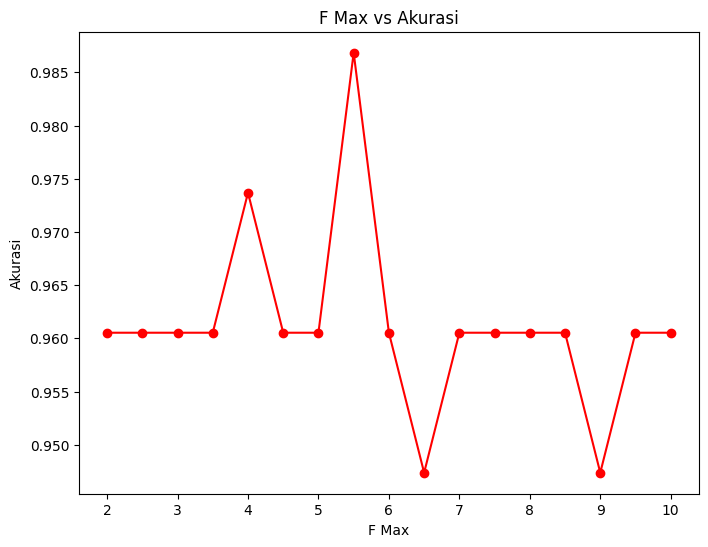

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiF_MAX['f_max'], nilaiF_MAX['best_fitness'], marker='o', linestyle='-', color='r')
plt.title('F Max vs Akurasi')
plt.xlabel('F Max')
plt.ylabel('Akurasi')
plt.show()

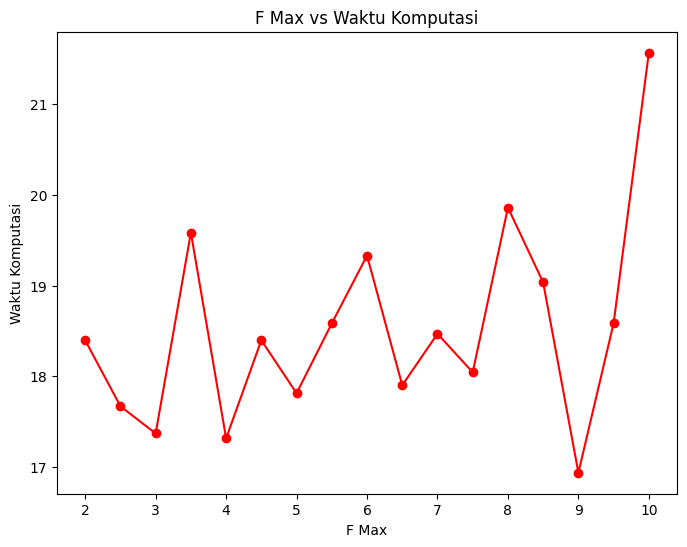

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiF_MAX['f_max'], nilaiF_MAX['duration'], marker='o', linestyle='-', color='r')
plt.title('F Max vs Waktu Komputasi')
plt.xlabel('F Max')
plt.ylabel('Waktu Komputasi')
plt.show()

##### Pengaruh alpha terhadap akurasi

In [54]:
def tuning():
    n_bats_values = [5]
    n_features = X.shape[1]
    max_iter_values = [100]
    f_min_values = [0] 
    f_max_values = [2]
    alpha_values = list(np.arange(0.8, 0.99, 0.02)) 
    gamma_values = [0.9]
    pulse_rate_values = [0.1] 
    loudness_values = [0.2]

    alpha_list = []
    best_solution_list = []
    best_features_list = []
    best_fitness_list = []
    duration_list = []

    i = 0
    for n_bats in n_bats_values:
        for max_iter in max_iter_values:
            for f_min in f_min_values:
                for f_max in f_max_values:
                    for alpha in alpha_values:
                        for gamma in gamma_values:
                            for pulse_rate in pulse_rate_values:
                                for loudness in loudness_values:
                                    i += 1
                                    print(f"\nKOMBINASI KE-{i}, ALPHA = {alpha}")
                                    start_time = time.time()
                                    # inisialisasi bba
                                    bba = BinaryBatAlgorithm(
                                        n_bats=n_bats,
                                        n_features=n_features,
                                        max_iter=max_iter,
                                        f_min=f_min,
                                        f_max=f_max,
                                        alpha=alpha,
                                        gamma=gamma,
                                        pulse_rate=pulse_rate,
                                        loudness=loudness
                                    )
                                    # optimasi
                                    best_solution, best_fitness = bba.optimize()
                                    end_time = time.time()
                                    durasi = end_time - start_time
                                    best_features = np.where(best_solution == 1)[0]
                                    # simpan ke list
                                    alpha_list.append(alpha)
                                    best_solution_list.append(best_solution)
                                    best_features_list.append(best_features)
                                    best_fitness_list.append(best_fitness)  
                                    duration_list.append(durasi) 
    hasil = pd.DataFrame({
        'alpha': alpha_list, 
        'best_solution': best_solution_list,
        'best_features': best_features_list,
        'best_fitness': best_fitness_list,
        'duration': duration_list
    })                                 
    return hasil

nilaiALPHA = tuning()
nilaiALPHA.to_csv('hasil uji/nilaiALPHA.csv', index=False)
nilaiALPHA.to_excel('hasil uji/nilaiALPHA.xlsx', index=False)


KOMBINASI KE-1, ALPHA = 0.8
Iteration 1, Best Fitness: 0.9605263157894737
Iteration 2, Best Fitness: 0.9605263157894737
Iteration 3, Best Fitness: 0.9605263157894737
Iteration 4, Best Fitness: 0.9605263157894737
Iteration 5, Best Fitness: 0.9605263157894737
Iteration 6, Best Fitness: 0.9605263157894737
Iteration 7, Best Fitness: 0.9736842105263158
Iteration 8, Best Fitness: 0.9736842105263158
Iteration 9, Best Fitness: 0.9736842105263158
Iteration 10, Best Fitness: 0.9736842105263158
Iteration 11, Best Fitness: 0.9736842105263158
Iteration 12, Best Fitness: 0.9736842105263158
Iteration 13, Best Fitness: 0.9736842105263158
Iteration 14, Best Fitness: 0.9736842105263158
Iteration 15, Best Fitness: 0.9736842105263158
Iteration 16, Best Fitness: 0.9736842105263158
Iteration 17, Best Fitness: 0.9736842105263158
Iteration 18, Best Fitness: 0.9736842105263158
Iteration 19, Best Fitness: 0.9736842105263158
Iteration 20, Best Fitness: 0.9736842105263158
Iteration 21, Best Fitness: 0.9736842105

In [55]:
nilaiALPHA

,alpha,best_solution,best_features,best_fitness,duration
0,0.80,"[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, ...","[0, 1, 2, 3, 4, 8, 9, 12, 14, 15, 16, 18, 20, ...",0.973684,18.546436
1,0.82,"[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0, 1, 2, 6, 7, 8, 11, 13, 14, 15, 19, 20, 21,...",0.973684,19.118114
2,0.84,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, ...","[0, 1, 2, 5, 7, 8, 9, 12, 16, 17, 18, 19, 20, ...",0.960526,18.188294
3,0.86,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 18, 2...",0.973684,17.902865
4,0.88,"[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, ...","[0, 4, 5, 8, 10, 11, 12, 13, 14, 17, 18, 19, 2...",0.986842,18.248007
5,0.90,"[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...","[0, 3, 6, 7, 9, 10, 11, 13, 14, 15, 17, 20, 21...",0.973684,18.180331
6,0.92,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[2, 3, 5, 10, 11, 14, 16, 17, 18, 25, 26, 27, ...",0.973684,17.674800
7,0.94,"[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...","[0, 1, 2, 3, 4, 7, 8, 10, 14, 15, 17, 18, 21, ...",0.986842,19.200767
8,0.96,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, ...","[0, 1, 7, 8, 10, 11, 12, 16, 17, 20, 21, 22, 2...",0.973684,19.948539
9,0.98,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 2, 4, 6, 7, 10, 11, 12, 14, 16, 18, 20, 22...",0.986842,20.066350


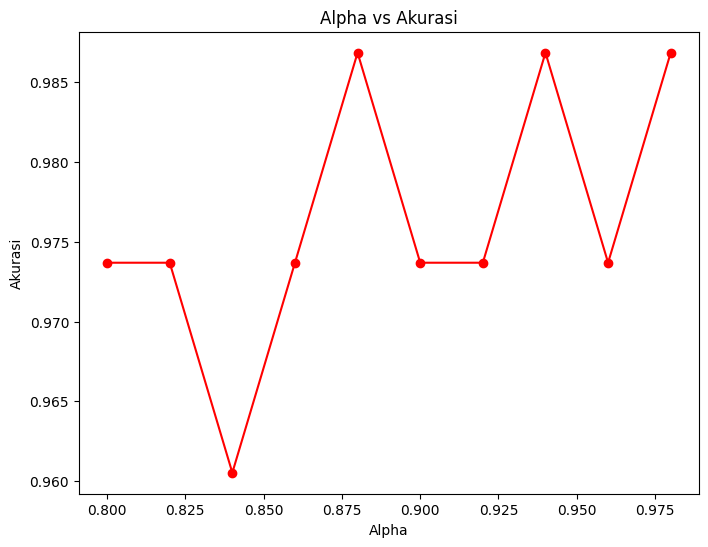

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiALPHA['alpha'], nilaiALPHA['best_fitness'], marker='o', linestyle='-', color='r')
plt.title('Alpha vs Akurasi')
plt.xlabel('Alpha')
plt.ylabel('Akurasi')
plt.show()

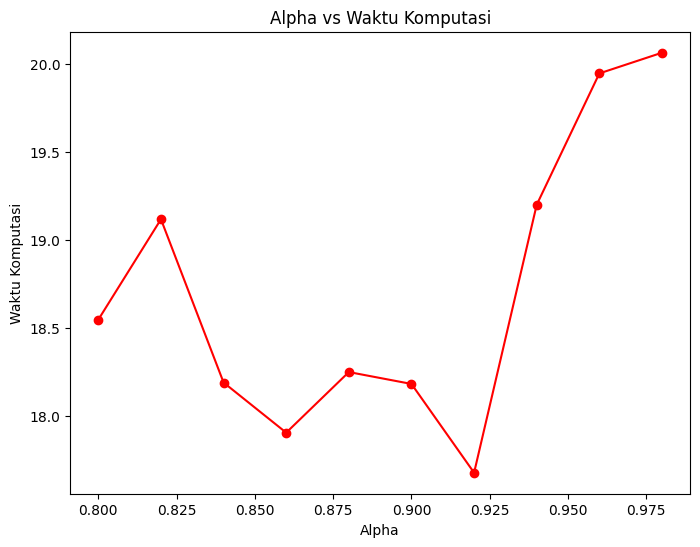

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiALPHA['alpha'], nilaiALPHA['duration'], marker='o', linestyle='-', color='r')
plt.title('Alpha vs Waktu Komputasi')
plt.xlabel('Alpha')
plt.ylabel('Waktu Komputasi')
plt.show()

##### Pengaruh gamma terhadap akurasi

In [68]:
def tuning():
    n_bats_values = [5]
    n_features = X.shape[1]
    max_iter_values = [100]
    f_min_values = [0] 
    f_max_values = [2]
    alpha_values = [0.8]
    gamma_values = list(np.arange(0.9, 1.01, 0.01))
    pulse_rate_values = [0.1] 
    loudness_values = [0.2]

    gamma_list = []
    best_solution_list = []
    best_features_list = []
    best_fitness_list = []
    duration_list = []

    i = 0
    for n_bats in n_bats_values:
        for max_iter in max_iter_values:
            for f_min in f_min_values:
                for f_max in f_max_values:
                    for alpha in alpha_values:
                        for gamma in gamma_values:
                            for pulse_rate in pulse_rate_values:
                                for loudness in loudness_values:
                                    i += 1
                                    print(f"\nKOMBINASI KE-{i}, GAMMA = {gamma}")
                                    start_time = time.time()
                                    # inisialisasi bba
                                    bba = BinaryBatAlgorithm(
                                        n_bats=n_bats,
                                        n_features=n_features,
                                        max_iter=max_iter,
                                        f_min=f_min,
                                        f_max=f_max,
                                        alpha=alpha,
                                        gamma=gamma,
                                        pulse_rate=pulse_rate,
                                        loudness=loudness
                                    )
                                    # optimasi
                                    best_solution, best_fitness = bba.optimize()
                                    end_time = time.time()
                                    durasi = end_time - start_time
                                    best_features = np.where(best_solution == 1)[0]
                                    # simpan ke list
                                    gamma_list.append(gamma)
                                    best_solution_list.append(best_solution)
                                    best_features_list.append(best_features)
                                    best_fitness_list.append(best_fitness)  
                                    duration_list.append(durasi) 
    hasil = pd.DataFrame({
        'gamma': gamma_list, 
        'best_solution': best_solution_list,
        'best_features': best_features_list,
        'best_fitness': best_fitness_list,
        'duration': duration_list
    })                                 
    return hasil

nilaiGAMMA = tuning()
nilaiGAMMA.to_csv('hasil uji/nilaiGAMMA.csv', index=False)
nilaiGAMMA.to_excel('hasil uji/nilaiGAMMA.xlsx', index=False)


KOMBINASI KE-1, GAMMA = 0.9
Iteration 1, Best Fitness: 0.9605263157894737
Iteration 2, Best Fitness: 0.9605263157894737
Iteration 3, Best Fitness: 0.9736842105263158
Iteration 4, Best Fitness: 0.9736842105263158
Iteration 5, Best Fitness: 0.9736842105263158
Iteration 6, Best Fitness: 0.9736842105263158
Iteration 7, Best Fitness: 0.9736842105263158
Iteration 8, Best Fitness: 0.9736842105263158
Iteration 9, Best Fitness: 0.9736842105263158
Iteration 10, Best Fitness: 0.9736842105263158
Iteration 11, Best Fitness: 0.9736842105263158
Iteration 12, Best Fitness: 0.9736842105263158
Iteration 13, Best Fitness: 0.9736842105263158
Iteration 14, Best Fitness: 0.9736842105263158
Iteration 15, Best Fitness: 0.9736842105263158
Iteration 16, Best Fitness: 0.9736842105263158
Iteration 17, Best Fitness: 0.9736842105263158
Iteration 18, Best Fitness: 0.9868421052631579
Iteration 19, Best Fitness: 0.9868421052631579
Iteration 20, Best Fitness: 0.9868421052631579
Iteration 21, Best Fitness: 0.9868421052

In [69]:
nilaiGAMMA

,gamma,best_solution,best_features,best_fitness,duration
0,0.90,"[1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[0, 2, 7, 8, 14, 15, 17, 20, 21, 24, 25, 27, 2...",0.986842,19.702849
1,0.91,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 3, 4, 11, 16, 17, 20, 23, 25, 27, 28, 2...",0.960526,17.050189
2,0.92,"[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0, 2, 3, 5, 6, 8, 12, 13, 14, 17, 19, 24, 25,...",0.960526,18.420314
3,0.93,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0, 2, 4, 5, 6, 8, 12, 13, 14, 17, 19, 22, 25,...",0.986842,17.255438
4,0.94,"[1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 2, 3, 4, 6, 9, 15, 16, 19, 20, 24, 25, 26,...",0.960526,18.531942
5,0.95,"[0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[2, 4, 5, 7, 9, 10, 11, 13, 14, 16, 17, 19, 22...",0.973684,18.420896
6,0.96,"[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[0, 1, 3, 4, 5, 8, 9, 11, 16, 19, 20, 21, 25, ...",0.960526,19.321716
7,0.97,"[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, ...","[0, 2, 6, 7, 9, 10, 11, 14, 15, 16, 20, 22, 23...",0.973684,21.057415
8,0.98,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18...",0.960526,24.917194
9,0.99,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 1, 5, 6, 8, 11, 18, 24, 25, 26, 28, 34, 35...",0.960526,18.321272


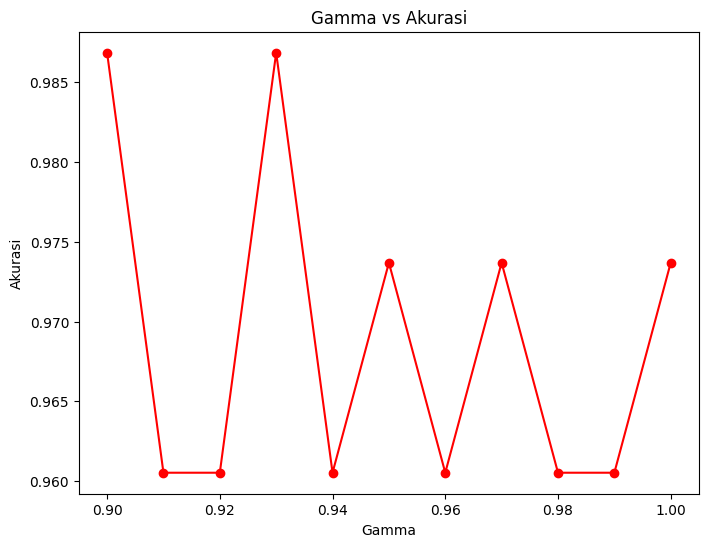

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiGAMMA['gamma'], nilaiGAMMA['best_fitness'], marker='o', linestyle='-', color='r')
plt.title('Gamma vs Akurasi')
plt.xlabel('Gamma')
plt.ylabel('Akurasi')
plt.show()

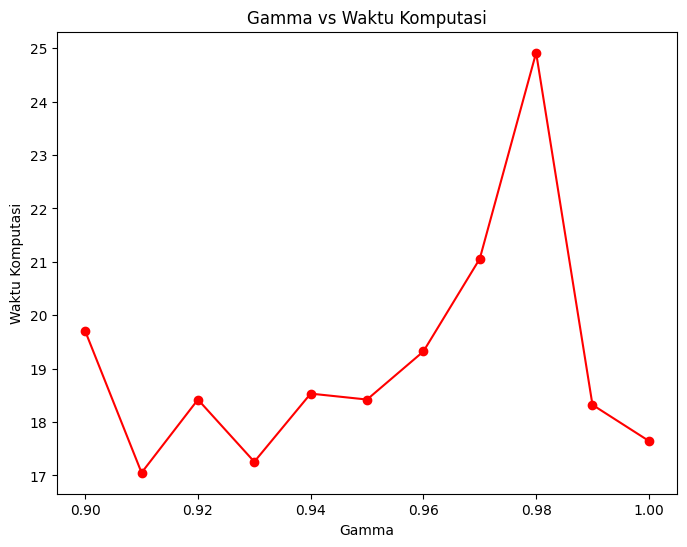

In [71]:
plt.figure(figsize=(8, 6))
plt.plot(nilaiGAMMA['gamma'], nilaiGAMMA['duration'], marker='o', linestyle='-', color='r')
plt.title('Gamma vs Waktu Komputasi')
plt.xlabel('Gamma')
plt.ylabel('Waktu Komputasi')
plt.show()